# Import

In [73]:
import os
import json
import posixpath
from IPython.display import Image

import pandas as pd
import numpy as np

import boto3
import sagemaker

# Set Up

## Global Parameters

In [77]:
# Define Region
region = "us-east-1"

# Define Bucket
bucket = "dsba-6190-final-team-project"
key_level_1 = "imgs"
key_level_2 = "test"

# Define Endpoint
endpoint_name = 'image-classification-drivers-endpoint'

## AWS Functions

In [79]:
# Establish Boto3 Session
boto_sess = boto3.session.Session(region_name=region)

# Invoke SageMaker Runtime Client
runtime = boto_sess.client(service_name='runtime.sagemaker')

# Invoke S3 Client
s3_client = boto_sess.client(service_name='s3')

# Invoke S3 Resource
s3_res = boto_sess.resource('s3')

# Import Test Images
The test images are located in the project S3 Bucket, under with the key prefix **imgs/test**.

## Generate List of Images
First, we create a list of all objects in the project bucket, under prefix **imgs/test**. 

In [65]:
s3_list_obj_param = {
    "Bucket" : bucket,
    "Prefix" : posixpath.join(key_level_1, key_level_2)
}

response = s3_client.list_objects_v2(**s3_list_obj_param)

The initial call returns a large amount of metadata we are not interested in. So we strip it down to just the contents of the the list. The contents still encapsulate a dictionary of file name and additional metadata. So we further strip this down to only extract the file names, aka, the value associated with the key.

We also add a filter to ensure all the contents we are collecting are JPG images.

In [66]:
# Extract Contents from Item Search Response
test_imgs_contents = response['Contents']

# Initialize List of Test Images
test_imgs_list = []

# Append Keys for Test Images
for item in test_imgs_contents:
    for key, value in item.items():
        if key == 'Key' and 'jpg' in value:
            test_imgs_list.append(value)
            
#print(test_imgs_list)

In [91]:
file_name = "test_data.jpg"
s3_res.Bucket(bucket).download_file(test_imgs_list[5], file_name)

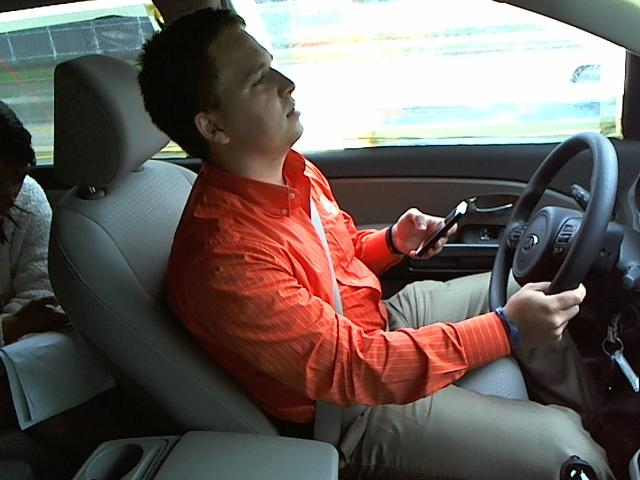

In [92]:
Image(file_name)

In [96]:
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

In [94]:
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
result = json.loads(result)
result

[0.01102517545223236,
 0.014701948501169682,
 0.007134982384741306,
 0.11257562786340714,
 0.012736225500702858,
 0.016208872199058533,
 0.757750391960144,
 0.017453305423259735,
 0.04680708795785904,
 0.003606359241530299]